# Exploratory Citation Network Analysis using NetworkX

### Importing all libraries and setting directory of XML files

In [2]:
import os
import itertools
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
path = ''
path1='PLOS Journals/PLoS_Pathog/'

## Creating a DataFrame which has 3 attributes:
1. Plos Article DOI 
2. Plos Article PMID
3. Reference PMID

This dataframe will be used later to find the pairwise edges in tuple form.

In [3]:
ref_all=[]
pmid_all=[]
doi_all=[]
for fn in os.listdir(path1):
    tree = ET.parse(path1+fn)  
    root = tree.getroot()    
    
    ref_list=[]
    pmid=0
    doi=0
    
    for elem in tree.iter(tag='article-id'):
        a=str(elem.attrib)
        if (a.find('pmid')>-1):        
            pmid=elem.text
        if (a.find('doi')>-1):        
            doi=elem.text
    for a in root.iter('ref'):
        for elem in a.iter('pub-id'):
            ref_list.append(elem.text)
            
    doi_list=np.repeat(doi,len(ref_list))
    pmid_list=np.repeat(pmid,len(ref_list))
    
    pmid_all.extend(pmid_list)
    doi_all.extend(doi_list)
    ref_all.extend(ref_list)
    
    
ref_source = pd.DataFrame(list(zip(doi_all,pmid_all,ref_all)),
              columns=['Doi','Pmid','Ref_Pmid']) 
    

In [4]:
ref_source.head()

,Doi,Pmid,Ref_Pmid
0,10.1371/journal.ppat.1003942,24586156,15115075
1,10.1371/journal.ppat.1003942,24586156,18322031
2,10.1371/journal.ppat.1003942,24586156,19787054
3,10.1371/journal.ppat.1003942,24586156,20709217
4,10.1371/journal.ppat.1003942,24586156,6408323


## Creating a reference dataframe of both PLoS articles and citations containing:
1. PMID
2. Journal Name
3. Article Name 

This can be used for enrichment purposes in the future through a simple join.

In [5]:
node_pmid=[]
node_journal=[]
node_title=[]


for fn in os.listdir(path1):
    tree = ET.parse(path1+fn)  
    root = tree.getroot()  
    
    for elem in tree.iter(tag='article-id'):
        a=str(elem.attrib)
        if (a.find('pmid')>-1):        
            node_pmid.append(elem.text)

    
    for a in root.iter('article-meta'):
        for elem in a.iter('article-title'):
            node_title.append(elem.text)

    for elem in tree.iter(tag='journal-title'):
        node_journal.append(elem.text)
    
    for a in root.iter('ref'):
        for elem in a.iter('source'):
            node_journal.append(elem.text)
        for elem in a.iter('pub-id'):
            node_pmid.append(elem.text)
        for elem in a.iter('article-title'):
            node_title.append(elem.text)
    
    
nodeDF = pd.DataFrame(list(zip(node_pmid,node_journal, node_title)),
              columns=['PMID','Journal','Title']) 
        

In [6]:
nodeDF.head()

,PMID,Journal,Title
0,24586156,PLoS Pathogens,‘Death and Axes’: Unexpected Ca
1,15115075,Southeast Asian Journal of Tropical Medicine a...,Egg production capacity of one-pair worms of S...
2,18322031,Chronic Illn,The unacknowledged impact of chronic schistoso...
3,19787054,PLoS Neglected Tropical Diseases,Schistosomiasis in Africa: an emerging tragedy...
4,20709217,Lancet,Africa is desperate for praziquantel


## Creating list for nodes and list of pairwise tuples for edges.

In [7]:
nodes=list(set(pmid_all+ref_all))

In [8]:
subset = ref_source[['Pmid', 'Ref_Pmid']]
tuples = [tuple(x) for x in subset.values]

In [9]:
tuples[2]

('24586156', '19787054')

## Generating a network graph using library NetworkX

In [10]:
import networkx as nx
G = nx.Graph()
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(tuples)

## Demonstration of how easily degrees of seperation between two nodes can be calculated once the network graph is built

In [12]:
deg_sep=nx.shortest_path_length(G, '24586156', '19787054')

In [13]:
print(deg_sep)

1


## Calculating other properties like centrality. 
Centrality is used to identify the most important nodes in a graph. As we can calculate the centrality of all nodes using NetworkX easily, this can be used as a parameter in the final product, perhaps for ranking recommendations. 

In [14]:
dict_centrality=nx.degree_centrality(G)

In [15]:
import pandas as pd
df=pd.DataFrame.from_dict(dict_centrality,orient='index')
df.columns=['Centrality']
df['PMID'] = df.index
df=df.reset_index(drop=True)
df.head()

,Centrality,PMID
0,0.000248,0
1,0.000005,20822789
2,0.000005,18981087
3,0.000005,11958927
4,0.000005,11075824


## Joining centrality dataframe with previously defined reference matrix on common PMID

In [16]:
centralityDF=df.merge(nodeDF, on='PMID',how='left')
centralityDF.head()

,Centrality,PMID,Journal,Title
0,0.000248,0,NaN,NaN
1,0.000005,20822789,Proc Natl Acad Sci U S A,"Insertional tagging, cloning, and expression o..."
2,0.000005,18981087,J Virol,Viral glycoprotein-mediated cell fusion assays...
3,0.000005,11958927,J Virol,Type I interferon signaling is required for ac...
4,0.000005,11075824,Proteins,Serologic evidence for regional differences in...


## Filtering out only PLOS journals and displaying top N.

In [17]:
centralityDF=centralityDF.dropna(axis=0, how='any')
plosCentralityDF=centralityDF[centralityDF['Journal'].str.contains('PLoS|plos|PLOS')]

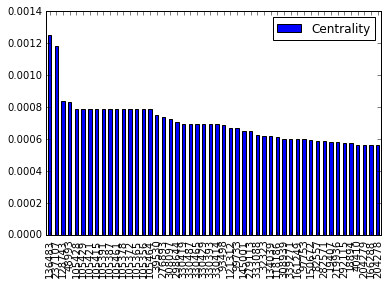

In [18]:
%matplotlib inline
plosCentralityDF.sort_values('Centrality',ascending=False).head(n=50).plot(kind='bar')

In [19]:
plosCentralityDF.sort_values('Centrality',ascending=False).head(n=50)

,Centrality,PMID,Journal,Title
136483,0.001252,25474413,PLoS Pathogens,Effect of passive antibody on congenital cytom...
237107,0.001184,24586147,PLoS Pathogens,Enhanced virulence of influenza A viruses with...
128743,0.000838,25299581,PLoS Pathog,Toxoplasma secreting Cre recombinase for analy...
48993,0.000833,26371761,PLoS One,The distribution and proliferation of the intr...
105428,0.000786,11846609,PLoS One,The Haemophilus ducreyi cytolethal distending ...
105429,0.000786,11846609,PLoS Pathogens,One-step inactivation of chromosomal genes in
105421,0.000786,11846609,PLoS One,Fcgamma receptors: old friends and new family ...
105415,0.000786,11846609,PLoS One,A second serine protease associated with manna...
105391,0.000786,11846609,PLoS Pathogens,Nuclease expression by
105387,0.000786,11846609,PLoS Pathogens,Yersinia pseudotuberculosis disseminates direc...
